# Muscle Activity Analysis for Reflex-only Controller

## Introduction

In this jupyter notebook, we will study the muscle activities of the various muscles of our human 2D musculoskeletal reflex model, adapted from Song and Geyer, 2015. We will then be able to compare the obtained results from the optimizations with experimental data from other research groups. 


This is done for the pure reflex controller, without added CPG. A reflex-only controller implies that this controller is based solely on feedbacks (uses sensory information only), as can be seen in different models from research: Geyer and al., 2010, Song et al., 2015. 

This type of control can demonstrate the significance of the reflex pathways in shaping the locomotor movement.


In [1]:
# Imports
from wNMF import wNMF
import numpy as np
import matplotlib.pyplot as plt   # allows to plot charts
import pandas as pd              
import seaborn as sns    # python data visualization library based on matplotlib
import glob
import pickle
import os 
# To sort tests per test_id
from collections import OrderedDict

# To be allow to zoom in on the plots, uncomment the following lines
# %matplotlib inline
# import mpld3
# mpld3.enable_notebook()

sns.set(style="darkgrid")


We first study 3 types of contribution and compare them with real experimental data:
- cpg: corresponds to the CPG contribution to the motoneurons, before the linear combination of the reflexes with the CPG
- reflex: corresponds to the reflex contribution to the motoneurons, before the linear combination of the reflexes with the CPG
- muscle: corresponds to motoneurons activities (which registers muscle activations)

Here, as we are focusing of a simple reflex model, the CPG contribution will not be studied as it is non-existent. We will look at the reflex and muscle contributions. (The CPG contribution is studied for the CPG-only model in the Jupyter notebook: Muscle_Activities_CPG.ipynb, and also in the CPG combined with reflexes model, as can be seen in the Jupyter notebook: Muscle_Activities_CPG_RFX.ipynb).

So, we will now study the different contributions to the motoneurons. To do so, we import the .pkl files from the optimizations. A PKL file is one that is created by the Python module 'pickle' that enables objects to be serialized. These files contain byte streams that represents the objects. Thus, after importing, we extract the different .pkl files. 

In [2]:
# Return a color map to assign colors to test_ids
def get_cmap(n, name='gist_rainbow'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

path_dir = "/home/efx/Desktop/osimrl_biorob/logs/simulation_data/RFX"

# Loop to recursively look for files with .pkl extension, even in subfolders
pkl_files = {}
for root, dirs, files in os.walk(path_dir):
    folder_name_splitted = root.split(os.sep)[-1].split('_')
    if(len(folder_name_splitted) == 2 and folder_name_splitted[0] == "Best"):
        test_id = folder_name_splitted[1]
        pkl_files[test_id] = []
        for file in files:
            if file.split('_')[-1:][0] in ["values.pkl", "reflex.pkl", "muscle.pkl", "noise.pkl"]:
                path = "{}{}{}".format(root, os.sep, file)
                pkl_files[test_id].append(path)

# Sort files per test_id asc
pkl_files = OrderedDict(sorted(pkl_files.items()))

# Color Map, assign a color to a test_id. The first test_id will be represented with the first color of the array aso...
possibleColors = get_cmap(len(pkl_files.keys()) + 1)
test_color = {}

# Open and load the files as dictionaries
# We store those dict in an bigger dict for futur reference, the filename will be the key
current_test = None
data = {}
count = 0
for test_id, files in pkl_files.items():
    if current_test != test_id:
        current_test = test_id
        data[current_test] = {}
        test_color[current_test] = possibleColors(count)
        count += 1
    for pkl in files:
        with open(pkl, 'rb') as f:
            data[current_test][pkl.split(os.sep)[-1].split('.')[-2].split('_')[-1]] = pickle.load(f)

##### Data structure #####
# values -> data['test_number']['values']
# reflex -> data['test_number']['reflex']
# muscle -> data['test_number']['muscle]
# noise -> data['test_number']['noise']

We create also a few functions that will be useful for the data analysis of this controller. 

In [3]:
# Interpolation for all cycles
def getNormalizedData(data, start_cycles, end_cycles):
    Y = []
    N = 100
    for start_cycle, end_cycle in zip(start_cycles, end_cycles):
        yp = data[start_cycle:end_cycle]
        xp = range(len(yp))
        x = np.linspace(0,len(yp),N)
        y = np.interp(x, xp, yp)
        Y.append(y)
    Y = np.array(Y).transpose()
    return Y

# Interpolation for one cycle
def NormalizationOneCycle(data, start_cycle_left):
    N = 100
    yp = data[start_cycle_left[0]:start_cycle_left[1]-1]
    xp = range(len(yp))
    x = np.linspace(0,len(yp),N)
    y = np.interp(x, xp, yp)

# Plot with the standard deviation around the mean
def plotWithStd(normalized_data, title, xlabel, ylabel, legendlabel, color, fontsize=15):
    m = np.mean(normalized_data,1)
    s = np.std(normalized_data,1)
    LENGTH = normalized_data.shape[0]
    
    plt.plot(m, label=legendlabel, color=color)
    plt.suptitle(title, fontsize=fontsize)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.legend()
    plt.fill_between(np.linspace(0,LENGTH,LENGTH),m-s, m+s ,alpha=0.3, color=color)
    
# Plot the standard deviation around the mean, for the vertical line showing the end of the stance phase
def plotStdStance(normalized_data, ymin, ymax, color, linestyle, fontsize):
    m = np.mean(normalized_data)
    max = np.max(normalized_data)
    min = np.min(normalized_data)
    plt.axvline(min, alpha=0, color=color)
    plt.axvline(max, alpha=0, color=color)
    plt.axvline(m, color=color)
    plt.fill_between([min, max], [ymax, ymax], alpha=0.3, color=color)

# Plots with the standard deviation around the mean for real human data
def plotMeanStd(norm_mean, norm_min, norm_max, title, xlabel, ylabel, legendlabel, legendLoc, color):
    LENGTH = norm_mean.shape[0]
    plt.plot(norm_mean, label=legendlabel, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc = legendLoc)
    plt.fill_between(np.linspace(0, LENGTH, LENGTH), norm_min, norm_max ,alpha=0.3, color=color)
    
# Cast value val to int
def CastValInt(dataframe):
    dataframe['index'] = dataframe['index'].astype(int)

# Cast value val to float
def CastValFloat(dataframe):
    dataframe['norm_min'] = dataframe['norm_min'].astype(float)
    dataframe['norm_mean'] = dataframe['norm_mean'].astype(float)
    dataframe['norm_max'] = dataframe['norm_max'].astype(float)

## Real human data

We retrieve real human data that is used in Geyer's article from 2010. These data correspond to the joint angles, as well as the ground reaction forces, and this will allow us to compare the results retrieved from our simulations with the real human data. 
In order to do this, we first retrieve the data and format it to be close to the type of data that we have from the simulations. We cast the different values and format the table. 

In [4]:
real_data_dir = '/home/efx/Desktop/osimrl_biorob/RealHumanData'

HipFlexion = pd.read_excel('{}{}HipFlexion.ods'.format(real_data_dir, os.sep), engine='odf')
KneeFlexion = pd.read_excel('{}{}KneeFlexion.ods'.format(real_data_dir, os.sep), engine='odf')
AnkleFlexion = pd.read_excel('{}{}AnkleFlexion.ods'.format(real_data_dir, os.sep), engine='odf')
GroundReactionForces = pd.read_excel('{}{}GroundReactionForces.ods'.format(real_data_dir, os.sep), engine='odf')

# Data formatting
HipFlex = pd.DataFrame(HipFlexion, columns=['index', 'norm_min', 'norm_mean', 'norm_max'])
KneeFlex = pd.DataFrame(KneeFlexion, columns=['index', 'norm_min', 'norm_mean', 'norm_max'])
AnkleFlex = pd.DataFrame(AnkleFlexion, columns=['index', 'norm_min', 'norm_mean', 'norm_max'])
GRF = pd.DataFrame(GroundReactionForces, columns=['index', 'norm_min', 'norm_mean', 'norm_max'])

# Casting
CastValInt(HipFlex)
CastValFloat(HipFlex)
CastValInt(KneeFlex)
CastValFloat(KneeFlex)
CastValInt(AnkleFlex)
CastValFloat(AnkleFlex)
CastValInt(GRF)
CastValFloat(GRF)

GRF.head()

## HIP JOINT ANGLE formatting 
HipFlex_mean = HipFlex['norm_mean']
HipFlex_min = HipFlex['norm_min']
HipFlex_max = HipFlex['norm_max']

# KNEE JOINT ANGLE formatting
KneeFlex_mean = KneeFlex['norm_mean']
KneeFlex_min = KneeFlex['norm_min']
KneeFlex_max = KneeFlex['norm_max']

# ANKLE JOINT ANGLE formatting
AnkleFlex_mean = AnkleFlex['norm_mean']
AnkleFlex_min = AnkleFlex['norm_min']
AnkleFlex_max = AnkleFlex['norm_max']

# GROUND REACTION FORCES formatting
GRF_mean = GRF['norm_mean']
GRF_min = GRF['norm_min']
GRF_max = GRF['norm_max']

## Plots

We will now plot our results obtained from the simulations to compare them with the real human data. 

### Ground reaction forces

We need to extract the ground reaction forces, especially along the y-direction, so as to determine the phases of the gait, i.e. whether the model is in the stance or swing phase. For that purpose, we retrieve the values from the Python dictionnary **values**. Then, we plot the ground reaction forces along the y-axis so as to differentiate the swing and stance phases of the gait cycle. By applying a threshold of 0.3, we will be able to differentiate the swing phase from the stance phase. 

(By plotting the array [450:450+125,], we can see only one cycle for each leg (left and right).)

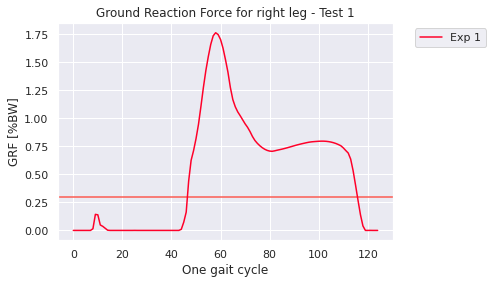

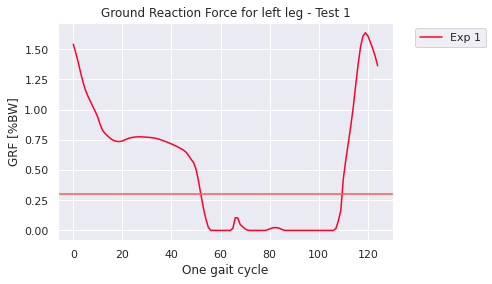

In [5]:
# Retrieval of the ground reaction forces along y-axis
grf_axis_y_rleg = {}
grf_axis_y_lleg = {}

for test_id, test in data.items():
    grf_axis_y_rleg[test_id] = [test['values'][i]["r_leg"]["ground_reaction_forces"][2] for i in range(len(test['values']))]
    grf_axis_y_lleg[test_id] = [test['values'][i]["l_leg"]["ground_reaction_forces"][2] for i in range(len(test['values']))]

# Plots of the GRF for the right and left leg separated
for test_id, grf in grf_axis_y_rleg.items(): 
    plt.axhline(y=0.3, color='xkcd:coral', linestyle='-')
    plt.plot(np.array(grf)[450:450+125,], color=test_color[test_id], label='Exp {}'.format(test_id))
    plt.title('Ground Reaction Force for right leg - Test {}'.format(test_id))
    plt.ylabel('GRF [%BW]')
    plt.xlabel('One gait cycle')
    plt.legend(bbox_to_anchor = (1.05, 1), loc='upper left')
# To display all plot independently, please put the plt.show method back in the for loop as below
    plt.show()

for test_id, grf in grf_axis_y_lleg.items(): 
    plt.plot(np.array(grf)[450:450+125,], color=test_color[test_id], label='Exp {}'.format(test_id))
    plt.axhline(y=0.3, color='xkcd:coral', linestyle='-')
    plt.title('Ground Reaction Force for left leg - Test {}'.format(test_id))
    plt.ylabel('GRF [%BW]')
    plt.xlabel('One gait cycle')
    plt.legend(bbox_to_anchor = (1.05, 1), loc='upper left')
    plt.show()

From the above plots, we can see the alternating behavior of both legs. Whilst the right leg enters the swing phase, the left leg is in stance phase, and vice versa. 

### Gait cycle

From the ground reaction forces, we can separate the full gait cycle into 2 phases, the stance and the swing phases. Thus, we try to separate the full walk into cycles based on the start of the cycle and the lift-off. From this, we can see that from START_CYCLE_l[0] to LIFT_OFF_l[0], we are in the **stance phase** and from LIFT_OFF_l[0] to START_CYCLE_l[1], we are in the **swing phase**. 

Then, we normalize the data with respect to time by a **linear interpolation**, to have all the cycles ranging from 0 to 100 which will be easier to analyze (all stance/swing cycles will be the same). We will also be able to determine the mean duration of one cycle. From this, we can plot the mean of the cycles as well as the standard deviations as can be seen below.

We can conclude that the stance phase is approximately 60% of the cycle, whereas the swing phase is 40% of one cycle. Thus, we will be able to compare this with the litterature to see the coherence of our results. 

In [6]:
# Separation in cycle + normalization of data + mean and std plot
GRF_Y_left = {}
GRF_Y_right = {}
for test_id, grf in grf_axis_y_lleg.items():
    GRF_Y_left[test_id] = np.array(grf)
for test_id, grf in grf_axis_y_rleg.items():
    GRF_Y_right[test_id] = np.array(grf)

START_CYCLE_l = {}
START_CYCLE_r = {}
for test_id, grf in GRF_Y_left.items():
    START_CYCLE_l[test_id] = np.where(np.diff(1.0*(grf > 0.3)) == 1)[0]
for test_id, grf in GRF_Y_right.items():
    START_CYCLE_r[test_id] = np.where(np.diff(1.0*(grf > 0.3)) == 1)[0]

dt = 0.01

# CYCLE DURATIONS FOR EACH SIMULATION
cycle_durations_left = {}
cycle_durations_right = {}
for test_id, start_cycles in START_CYCLE_l.items():
    cycle_durations_left[test_id] = (start_cycles[1:] - start_cycles[:-1])*dt   # in seconds
for test_id, start_cycles in START_CYCLE_r.items():
    cycle_durations_right[test_id] = (start_cycles[1:] - start_cycles[:-1])*dt  # in seconds
    
# Mean duration for each leg
mean_duration_left = {}
mean_duration_right = {}
for test_id, start_cycles in cycle_durations_left.items():
    mean_duration_left[test_id] = np.mean(cycle_durations_left[test_id])
for test_id, start_cycles in cycle_durations_right.items():
    mean_duration_right[test_id] = np.mean(cycle_durations_right[test_id])  
    
# Mean duration overall
mean_duration = {}
for test_id, start_cycles in mean_duration_left.items():
    for test_id, start_cycles in mean_duration_right.items():
        mean_duration[test_id] = (mean_duration_left[test_id] + mean_duration_right[test_id])/2

print(mean_duration)

# STANCES AND SWINGS
LIFT_OFF_l = {}
LIFT_OFF_r = {}
for test_id, grf in GRF_Y_left.items():
    LIFT_OFF_l[test_id] = np.where(np.diff(1.0*(grf > 0.3)) == -1)[0]
for test_id, grf in GRF_Y_right.items():
    LIFT_OFF_r[test_id] = np.where(np.diff(1.0*(grf > 0.3)) == -1)[0]
    
# CONDITIONS
for test_id, start_cycles in START_CYCLE_l.items():
    if(start_cycles[0] > LIFT_OFF_l[test_id][0]):
        LIFT_OFF_l[test_id] = LIFT_OFF_l[test_id][1:]
for test_id, start_cycles in START_CYCLE_r.items():
    if(start_cycles[0] > LIFT_OFF_r[test_id][0]):
        LIFT_OFF_r[test_id] = LIFT_OFF_r[test_id][1:]
for test_id, lift_off in LIFT_OFF_l.items():
    lift_off = lift_off[len(START_CYCLE_l[test_id])-len(lift_off):]
for test_id, lift_off in LIFT_OFF_r.items():
    lift_off = lift_off[len(START_CYCLE_r[test_id])-len(lift_off):]    
for test_id, lift_off in LIFT_OFF_l.items():
    if (len(LIFT_OFF_l[test_id]) > len(cycle_durations_left[test_id])):
        LIFT_OFF_l[test_id] = LIFT_OFF_l[test_id][:-1]
for test_id, lift_off in LIFT_OFF_r.items():
    if (len(LIFT_OFF_r[test_id]) > len(cycle_durations_right[test_id])):
        LIFT_OFF_r[test_id] = LIFT_OFF_r[test_id][:-1]     

# STANCE/SWING durations - LEFT 
stance_durations_left = {}
swing_durations_left = {}
for test_id, lift_off in LIFT_OFF_l.items():
    stance_durations_left[test_id] = (lift_off - START_CYCLE_l[test_id][:len(lift_off)])*dt  # in seconds
    swing_durations_left[test_id] = (START_CYCLE_l[test_id][len(START_CYCLE_l[test_id]) - len(lift_off):] - lift_off)*dt  # in seconds
#print(stance_durations_left)
#print(swing_durations_left)

# STANCE/SWING durations - RIGHT
stance_durations_right = {}
swing_durations_right = {}
for test_id, lift_off in LIFT_OFF_r.items():
    stance_durations_right[test_id] = (lift_off - START_CYCLE_r[test_id][:len(lift_off)])*dt  # in seconds
    swing_durations_right[test_id] = (START_CYCLE_r[test_id][len(START_CYCLE_r[test_id]) - len(lift_off):] - lift_off)*dt  # in seconds
#print(stance_durations_right)
#print(swing_durations_right)

{'1': 1.2333928571428572}


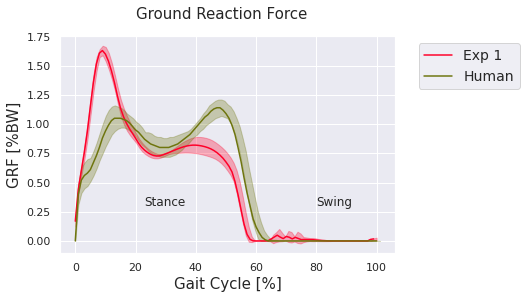

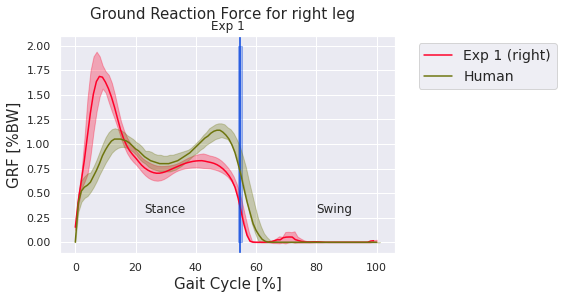

In [7]:
# Normalize data using pre-defined function
GRF_Y_norm_l = {}
GRF_Y_norm_r = {}
for test_id, grf in GRF_Y_left.items():
    GRF_Y_norm_l[test_id] = getNormalizedData(grf, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)
for test_id, grf in GRF_Y_right.items():
    GRF_Y_norm_r[test_id] = getNormalizedData(grf, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)

stance_norm_l = {}
stance_norm_r = {}
swing_norm_l = {}
swing_norm_r = {}

for test_id, duration in stance_durations_left.items():
    stance_norm_l[test_id] = (duration[:len(cycle_durations_left[test_id])]/cycle_durations_left[test_id])*100
for test_id, duration in stance_durations_right.items():
    stance_norm_r[test_id] = (duration[:len(cycle_durations_right[test_id])]/cycle_durations_right[test_id])*100
for test_id, duration in swing_durations_left.items():
    swing_norm_l[test_id] = (duration[:len(cycle_durations_left[test_id])]/cycle_durations_left[test_id])*100
for test_id, duration in swing_durations_right.items():
    swing_norm_r[test_id] = (duration[:len(cycle_durations_right[test_id])]/cycle_durations_right[test_id])*100

# Plots of the normalized ground reaction forces, compared to real human data for the right and left legs.
for test_id, grf in GRF_Y_norm_l.items():
    plotWithStd(grf, 'Ground Reaction Force', 'Gait Cycle [%]', 'GRF [%BW]', 'Exp {}'.format(test_id), test_color[test_id], 15)
    #plotStdStance(stance_norm_l[test_id], 0, 2, 'xkcd:blue', 'dashed', 17)
    plt.text(23, 0.3, 'Stance')
    plt.text(80, 0.3, 'Swing')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plotMeanStd(GRF_mean, GRF_min, GRF_max, '', 'Gait Cycle [%]', 'GRF [%BW]', 'Human', 'upper right', 'xkcd:olive')   
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.show()

for test_id, grf in GRF_Y_norm_r.items():
    plotWithStd(grf, 'Ground Reaction Force for right leg', 'Gait Cycle [%]', 'GRF [%BW]', 'Exp {} (right)'.format(test_id), test_color[test_id], 15)
    plotStdStance(stance_norm_r[test_id], 0, 2, 'xkcd:blue', 'dashed', 17)
    plotMeanStd(GRF_mean, GRF_min, GRF_max, 'Exp {}'.format(test_id), 'Gait Cycle [%]', 'GRF [%BW]', 'Human', 'upper right', 'xkcd:olive')
    plt.text(23, 0.3, 'Stance')
    plt.text(80, 0.3, 'Swing')
    plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
    plt.show()

From these plots, we can observe the stance and swing phases. We compare our results with the real human data, and we can see that the stance phase is just a little bit shorter for us than in real humans. We also have an overshoot at the beginning of the stance phase which is quite larger than the actual data. 


We now want to determine the different phases durations in one cycle, as well as the duration of the various gait cycles for one optimization, for the left and right legs.

### Muscle activations

We then look at the various muscle activations. We will be able to view if the activities we are recording are in accordance with human muscle activities during locomotion. 
First, we retrieve the values of the different muscle activations for both legs, before separating them into 5 parts:
- Muscles involved only in the hip
- Muscles involved only in the knee
- Muscles involved only in the ankle
- Biarticular muscles for the joint hip/knee
- Biarticular muscles for the joint knee/ankle

From this, we can obtain five different plots.

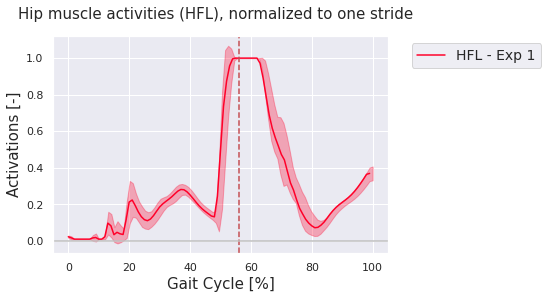

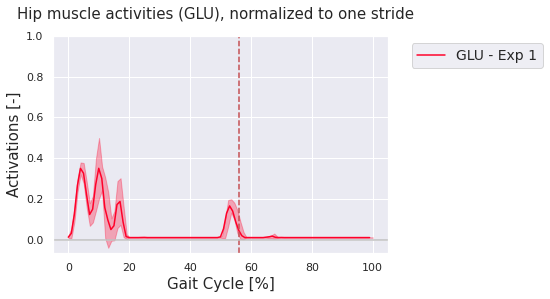

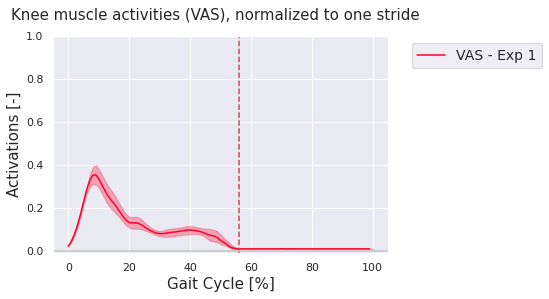

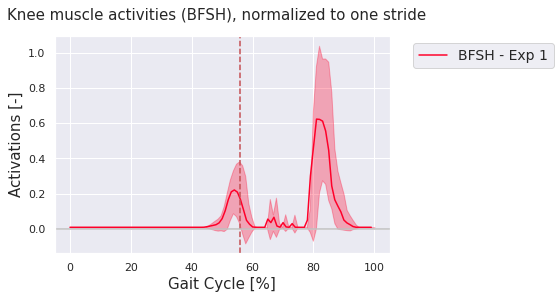

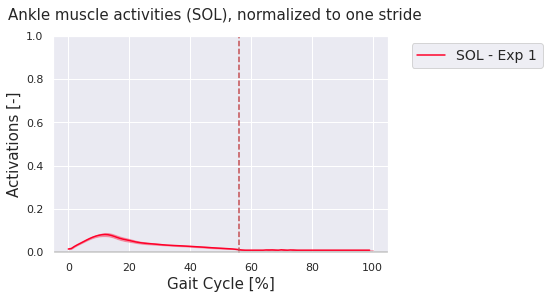

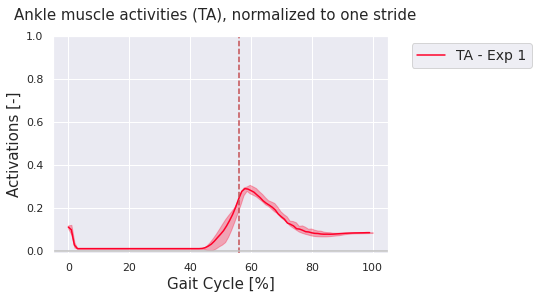

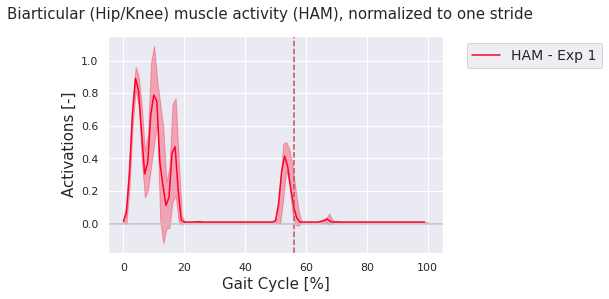

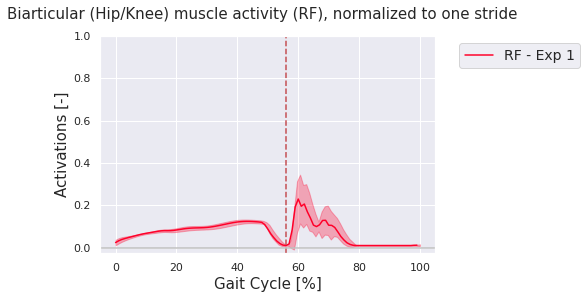

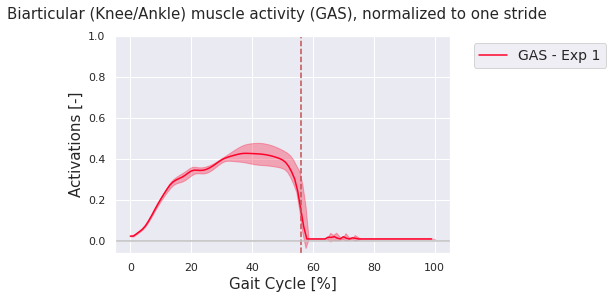

In [8]:
muscle_activations = {}
for test_id, test in data.items():
    muscle_activations[test_id] = [test['muscle'][i] for i in range(len(data[test_id]['muscle']))]

# Muscle activations from the muscles of the right leg
HFL_r  = {}
GLU_r  = {}
HAM_r  = {}
RF_r   = {}
VAS_r  = {}
BFSH_r = {}
GAS_r  = {}
SOL_r  = {}
TA_r   = {}

for test_id, muscle_activation in muscle_activations.items():
    HFL_r[test_id]  = np.clip([item[2] for item in muscle_activation], 0.01, 1)
    GLU_r[test_id]  = np.clip([item[3] for item in muscle_activation], 0.01, 1)
    HAM_r[test_id]  = np.clip([item[4] for item in muscle_activation], 0.01, 1)
    RF_r[test_id]   = np.clip([item[5] for item in muscle_activation], 0.01, 1)
    VAS_r[test_id]  = np.clip([item[6] for item in muscle_activation], 0.01, 1)
    BFSH_r[test_id] = np.clip([item[7] for item in muscle_activation], 0.01, 1)
    GAS_r[test_id]  = np.clip([item[8] for item in muscle_activation], 0.01, 1)
    SOL_r[test_id]  = np.clip([item[9] for item in muscle_activation], 0.01, 1)
    TA_r[test_id]  =  np.clip([item[10] for item in muscle_activation], 0.01, 1)
    
# Muscle activations from the muscles of the left leg
HFL_l  = {}
GLU_l  = {}
HAM_l  = {}
RF_l   = {}
VAS_l  = {}
BFSH_l = {}
GAS_l  = {}
SOL_l  = {}
TA_l   = {}

for test_id, muscle_activation in muscle_activations.items():
    HFL_l[test_id]  = np.clip([item[13] for item in muscle_activation], 0.01, 1)
    GLU_l[test_id]  = np.clip([item[14] for item in muscle_activation], 0.01, 1)
    HAM_l[test_id]  = np.clip([item[15] for item in muscle_activation], 0.01, 1)
    RF_l[test_id]   = np.clip([item[16] for item in muscle_activation], 0.01, 1)
    VAS_l[test_id]  = np.clip([item[17] for item in muscle_activation], 0.01, 1)
    BFSH_l[test_id] = np.clip([item[18] for item in muscle_activation], 0.01, 1)
    GAS_l[test_id]  = np.clip([item[19] for item in muscle_activation], 0.01, 1)
    SOL_l[test_id]  = np.clip([item[20] for item in muscle_activation], 0.01, 1)
    TA_l[test_id]   = np.clip([item[21] for item in muscle_activation], 0.01, 1)

# Normalized muscle activities involved in the hip only (HFL, GLU)
HFL_r_norm = {}
HFL_l_norm = {}
GLU_r_norm = {}
GLU_l_norm = {}

for test_id, hfl in HFL_r.items():
    HFL_r_norm[test_id] = getNormalizedData(hfl, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, hfl in HFL_l.items():
    HFL_l_norm[test_id] = getNormalizedData(hfl, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)
for test_id, glu in GLU_r.items():
    GLU_r_norm[test_id] = getNormalizedData(glu, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, glu in GLU_l.items():
    GLU_l_norm[test_id] = getNormalizedData(glu, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)   

# Plot of the hip muscle activities for both legs
for test_id in HFL_r_norm.keys():
    #plotWithStd(HFL_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'HFL_r', 'xkcd:red')
    plotWithStd(HFL_l_norm[test_id], 'Hip muscle activities (HFL), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'HFL - Exp {}'.format(test_id), test_color[test_id],15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart    
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(0, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show()

# Plot of the hip muscle activities for both legs
for test_id in GLU_r_norm.keys():
    #plotWithStd(GLU_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'GLU_r', 'xkcd:orange')
    plotWithStd(GLU_l_norm[test_id], 'Hip muscle activities (GLU), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'GLU - Exp {}'.format(test_id), test_color[test_id], 15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(0, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show() 
    
# Normalized muscle activities involved in the knee only (VAS, BFSH)
VAS_r_norm = {}
VAS_l_norm = {}
BFSH_r_norm = {}
BFSH_l_norm = {}

for test_id, vas in VAS_r.items():
    VAS_r_norm[test_id] = getNormalizedData(vas, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, vas in VAS_l.items():
    VAS_l_norm[test_id] = getNormalizedData(vas, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)
for test_id, bfsh in BFSH_r.items():
    BFSH_r_norm[test_id] = getNormalizedData(bfsh, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, bfsh in BFSH_l.items():
    BFSH_l_norm[test_id] = getNormalizedData(bfsh, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1) 

# Plot of the knee muscle activities for both legs
for test_id in VAS_r_norm.keys():
    #plotWithStd(VAS_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'VAS_r', 'xkcd:red')
    plotWithStd(VAS_l_norm[test_id], 'Knee muscle activities (VAS), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'VAS - Exp {}'.format(test_id), test_color[test_id], 15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(0, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show()
    
# Plot of the knee muscle activities for both legs
for test_id in BFSH_r_norm.keys():
    #plotWithStd(BFSH_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'BFSH_r', 'xkcd:orange')
    plotWithStd(BFSH_l_norm[test_id], 'Knee muscle activities (BFSH), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'BFSH - Exp {}'.format(test_id), test_color[test_id], 15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.show()

# Normalized muscle activities involved in the ankle only (SOL, TA)
SOL_r_norm = {}
SOL_l_norm = {}
TA_r_norm = {}
TA_l_norm = {}

for test_id, sol in SOL_r.items():
    SOL_r_norm[test_id] = getNormalizedData(sol, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, sol in SOL_l.items():
    SOL_l_norm[test_id] = getNormalizedData(sol, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)
for test_id, ta in TA_r.items():
    TA_r_norm[test_id] = getNormalizedData(ta, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, ta in TA_l.items():
    TA_l_norm[test_id] = getNormalizedData(ta, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1) 

# Plot of the ankle muscle activities for both legs
for test_id in SOL_r_norm.keys():
    #plotWithStd(SOL_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'SOL_r', 'xkcd:red')
    plotWithStd(SOL_l_norm[test_id], 'Ankle muscle activities (SOL), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'SOL - Exp {}'.format(test_id), test_color[test_id], 15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(0, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show()
    
# Plot of the ankle muscle activities for both legs
for test_id in TA_r_norm.keys():
    #plotWithStd(TA_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'TA_r', 'xkcd:orange')
    plotWithStd(TA_l_norm[test_id], 'Ankle muscle activities (TA), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'TA - Exp {}'.format(test_id), test_color[test_id], 15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(0, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show()

# Normalized biarticular muscle activities for the joint hip/knee (HAM, RF)
HAM_r_norm = {}
HAM_l_norm = {}
RF_r_norm = {}
RF_l_norm = {}
for test_id, ham in HAM_r.items():
    HAM_r_norm[test_id] = getNormalizedData(ham, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, ham in HAM_l.items():
    HAM_l_norm[test_id] = getNormalizedData(ham, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)
for test_id, rf in RF_r.items():
    RF_r_norm[test_id] = getNormalizedData(rf, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, rf in RF_l.items():
    RF_l_norm[test_id] = getNormalizedData(rf, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1) 

# Plot of the biarticular muscle activities from joint hip/knee
for test_id in HAM_r_norm.keys():
    #plotWithStd(HAM_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'HAM_r', 'xkcd:red')
    plotWithStd(HAM_l_norm[test_id], 'Biarticular (Hip/Knee) muscle activity (HAM), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'HAM - Exp {}'.format(test_id), test_color[test_id], 15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(0, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show()

# Plot of the biarticular muscle activities from joint hip/knee
for test_id in RF_r_norm.keys():
    #plotWithStd(RF_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'RF_r', 'xkcd:orange')
    plotWithStd(RF_l_norm[test_id], 'Biarticular (Hip/Knee) muscle activity (RF), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'RF - Exp {}'.format(test_id), test_color[test_id], 15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(0, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show()

# Normalized biarticular muscle activity for the joint knee/ankle (GAS)
GAS_r_norm = {}
GAS_l_norm = {}
for test_id, gas in GAS_r.items():
    GAS_r_norm[test_id] = getNormalizedData(gas, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, gas in GAS_l.items():
    GAS_l_norm[test_id] = getNormalizedData(gas, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)

# Plot of the biarticular muscle activity from the joint knee/ankle
for test_id in GAS_r_norm.keys():
    #plotWithStd(GAS_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'GAS_r', 'xkcd:orange')
    plotWithStd(GAS_l_norm[test_id], 'Biarticular (Knee/Ankle) muscle activity (GAS), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'GAS - Exp {}'.format(test_id), test_color[test_id], 15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(0, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show()

These plots will allow us to compare the results with real human data, that can be seen in Geyer's article. 

### Joint Angles 

We now look at the angles from the various joints (hip, knee, ankle) and plot both legs on one graph, using again the normalized data from the values dictionnary, with mean and standard deviation. We will compare this with real human data. 

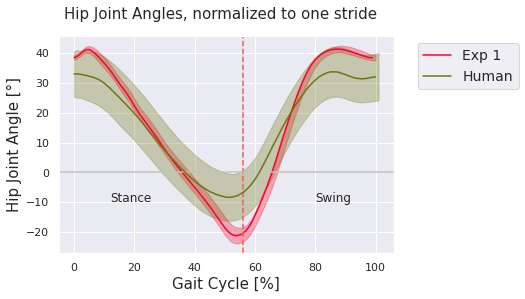

[187 313 436 559 685 805 930]


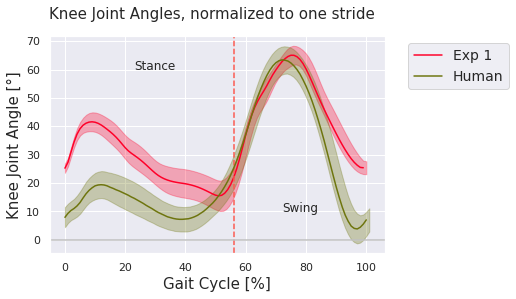

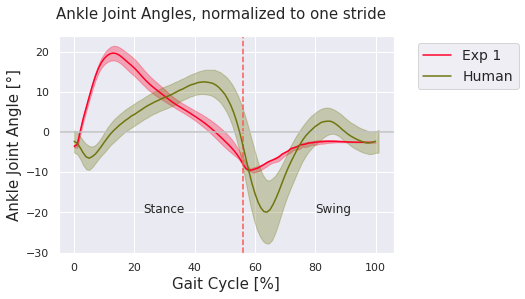

In [9]:
## HIP JOINT ANGLES
# Retrieve the output from the optimizations
hip_angle_rleg = {}
hip_angle_lleg = {}
for test_id, test in data.items():
    hip_angle_rleg[test_id] = [test['values'][i]["r_leg"]["joint"]["hip"] * 180/np.pi for i in range(len(test['values']))]
    hip_angle_lleg[test_id] = [test['values'][i]["l_leg"]["joint"]["hip"] * 180/np.pi for i in range(len(test['values']))]

# Normalize data
hip_norm_left = {}
hip_norm_right = {}
for test_id, hip_angle in hip_angle_lleg.items():
    hip_norm_left[test_id] = getNormalizedData(hip_angle, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)
for test_id, hip_angle in hip_angle_rleg.items():
    hip_norm_right[test_id] = getNormalizedData(hip_angle, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)

# Multiply the norms by -1 to follow the conventions of various articles and plot against real human data
for test_id in hip_norm_left.keys():
    plotWithStd(-1*hip_norm_left[test_id], 'Hip Joint Angles, normalized to one stride', 'Gait Cycle [%]', 'Angles [°]', 'Exp {}'.format(test_id), test_color[test_id], 15)
    #plotWithStd(-1*hip_norm_right[test_id], 'Hip angles for both legs', 'Gait Cycle [%]', 'Angles [°]', 'Right (model)', 'xkcd:blue')
    plt.axvline(56, 0, 2, color='xkcd:coral', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    plt.text(12, -10, 'Stance')
    plt.text(80, -10, 'Swing')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plotMeanStd(HipFlex_mean, HipFlex_min, HipFlex_max, '', 'Gait Cycle [%]', 'Hip Joint Angle [°]', 'Human', 'lower right', 'xkcd:olive')
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.show()

# KNEE JOINT ANGLES
# Retrieve the output from the optimizations
knee_angle_rleg = {}
knee_angle_lleg = {}
for test_id, test in data.items():
    knee_angle_rleg[test_id] = [(test['values'][i]["r_leg"]["joint"]["knee"])* 180/np.pi for i in range(len(test['values']))]
    knee_angle_lleg[test_id] = [(test['values'][i]["l_leg"]["joint"]["knee"])* 180/np.pi for i in range(len(test['values']))]

print(START_CYCLE_l[test_id][1:])
    
# Normalize data
knee_norm_left = {}
knee_norm_right = {}
for test_id, knee in knee_angle_lleg.items():
    knee_norm_left[test_id] = getNormalizedData(knee, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)
for test_id, knee in knee_angle_rleg.items():
    knee_norm_right[test_id] = getNormalizedData(knee, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)


# Multiply the norms by -1 to follow convention, and plot against real human data
for test_id in knee_norm_left.keys():
    plotWithStd(-1*knee_norm_left[test_id], 'Knee Joint Angles, normalized to one stride', 'Gait Cycle [%]', 'Angles [°]', 'Exp {}'.format(test_id), test_color[test_id], 15)
    #plotWithStd(-1*knee_norm_right[test_id], 'Knee angles for both legs', 'Gait Cycle [%]', 'Angles [°]', 'Right (model)', 'xkcd:blue')
    plt.axvline(56, 0, 2, color='xkcd:coral', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    plt.text(23, 60, 'Stance')
    plt.text(72, 10, 'Swing')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plotMeanStd(KneeFlex_mean, KneeFlex_min, KneeFlex_max, '', 'Gait Cycle [%]', 'Knee Joint Angle [°]', 'Human', 'upper left', 'xkcd:olive')
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.show()

# ANKLE JOINT ANGLES
# Retrieve the output from the optimizations
ankle_angle_rleg = {}
ankle_angle_lleg = {}
for test_id, test in data.items():
    ankle_angle_rleg[test_id] = [(test['values'][i]["r_leg"]["joint"]["ankle"])* 180/np.pi for i in range(len(test['values']))]
    ankle_angle_lleg[test_id] = [(test['values'][i]["l_leg"]["joint"]["ankle"])* 180/np.pi for i in range(len(test['values']))]

# Normalize data
ankle_norm_left = {}
ankle_norm_right = {}
for test_id, ankle in ankle_angle_lleg.items():
    ankle_norm_left[test_id] = getNormalizedData(ankle, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)
for test_id, ankle in ankle_angle_rleg.items():
    ankle_norm_right[test_id] = getNormalizedData(ankle, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)

# Multiply the norms by -1 to follow convention, and plot against real human data
for test_id in ankle_norm_left.keys():
    plotWithStd(-1*ankle_norm_left[test_id], 'Ankle Joint Angles, normalized to one stride', 'Gait Cycle [%]', 'Angles [°]', 'Exp {}'.format(test_id), test_color[test_id], 15)
    #plotWithStd(-1*ankle_norm_right[test_id], 'Ankle angles for both legs', 'Gait Cycle [%]', 'Angles [°]', 'Right (model)', 'xkcd:blue')
    plt.axvline(56, 0, 2, color='xkcd:coral', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    plt.text(23, -20, 'Stance')
    plt.text(80, -20, 'Swing')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plotMeanStd(AnkleFlex_mean+20, AnkleFlex_min+20, AnkleFlex_max+20, '', 'Gait Cycle [%]', 'Ankle Joint Angle [°]', 'Human', 'lower left', 'xkcd:olive')
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.show()

From the plots above, we can see that:
- Concerning the hip flexion: The results are quite close to experimental data, with a mean value a little bit higher in our results at the beginning of the stance phase and end of the swing phase. The general curve is very consistant with data obtained from human.
- Concerning the knee flexion: The trend is similar to human data. However, the values are too high during the stance phase, in our case. Some tuning is necessary to obtain better results. 
- Concerning the ankle flexio: The trend, once again, is quite similar. Our values, for both the stance and swing phases are too high compared to experimental data. We should try other optimizations to obtain better results. 

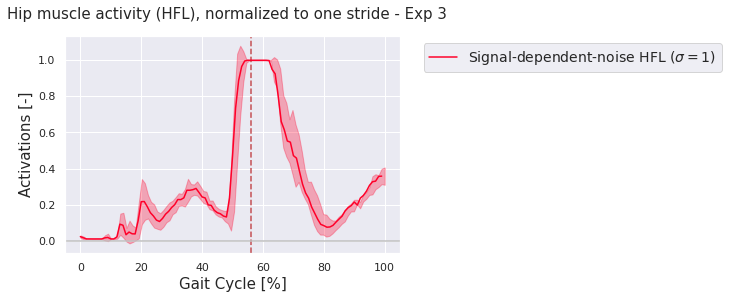

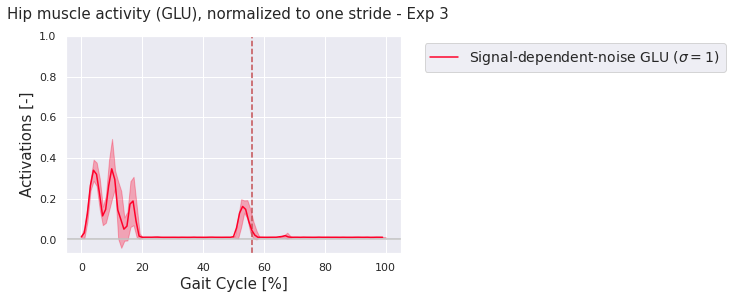

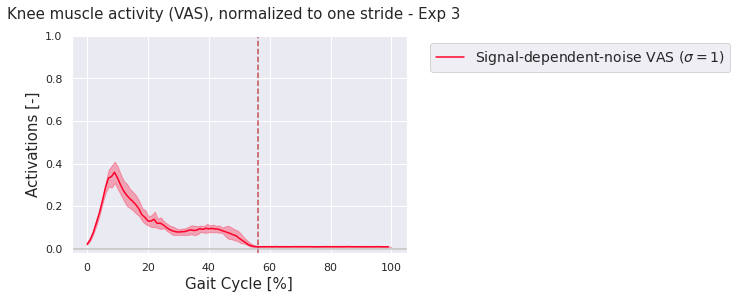

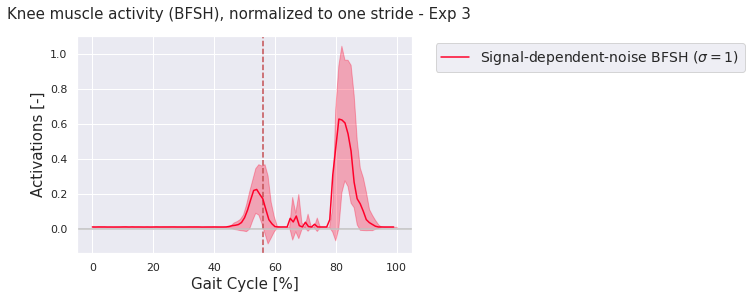

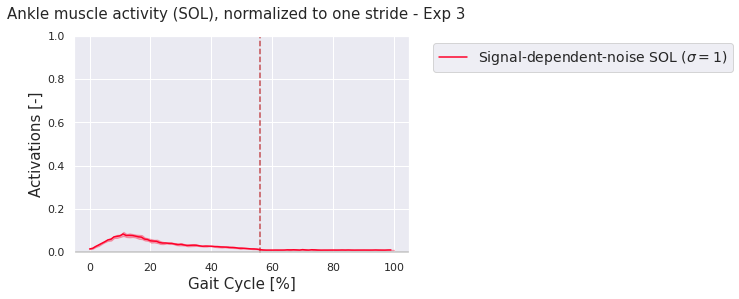

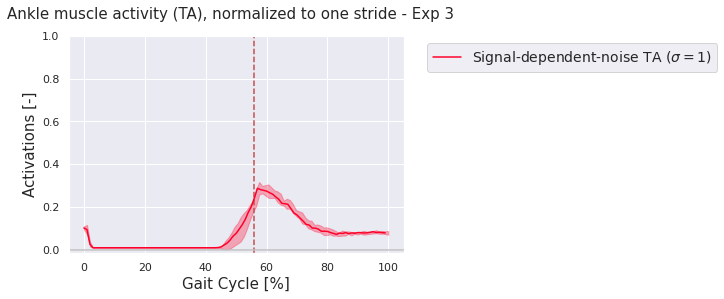

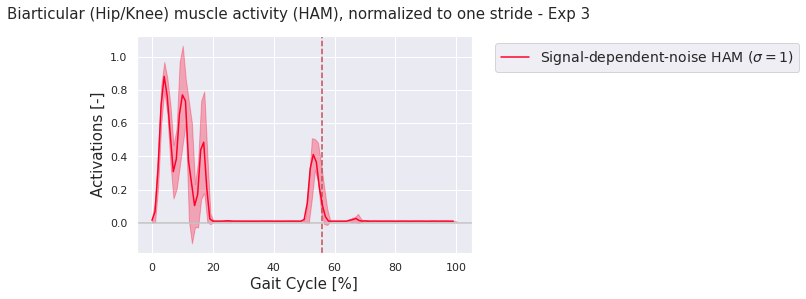

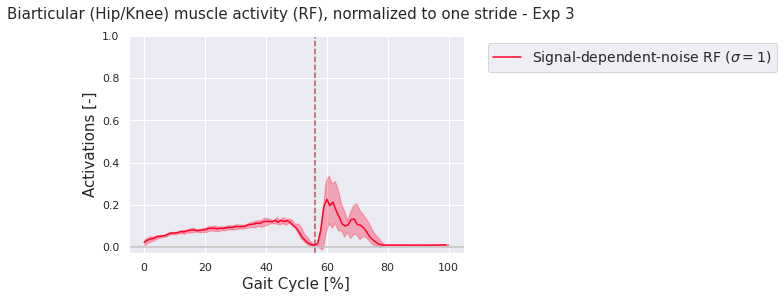

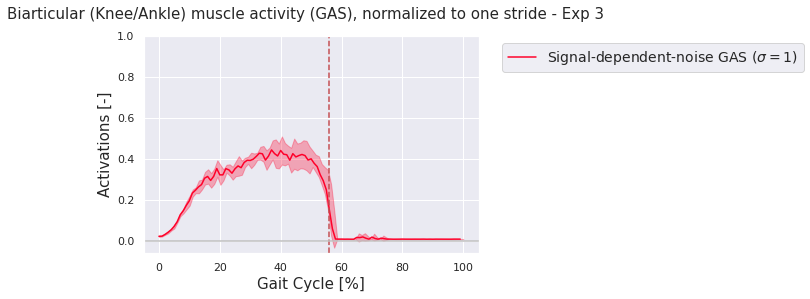

In [10]:
noise = {}
for test_id, test in data.items():
    noise[test_id] = [test['noise'][i] for i in range(len(data[test_id]['noise']))]

# Muscle noise added to the muscle activations from the muscles of the right leg with noise
HFL_r_noise  = {}
GLU_r_noise  = {}
HAM_r_noise  = {}
RF_r_noise   = {}
VAS_r_noise  = {}
BFSH_r_noise = {}
GAS_r_noise  = {}
SOL_r_noise  = {}
TA_r_noise   = {}

for test_id, noise_act in noise.items():
    HFL_r_noise[test_id]  = np.clip([item[2] for item in noise_act], 0.01, 1)
    GLU_r_noise[test_id]  = np.clip([item[3] for item in noise_act], 0.01, 1)
    HAM_r_noise[test_id]  = np.clip([item[4] for item in noise_act], 0.01, 1)
    RF_r_noise[test_id]   = np.clip([item[5] for item in noise_act], 0.01, 1)
    VAS_r_noise[test_id]  = np.clip([item[6] for item in noise_act], 0.01, 1)
    BFSH_r_noise[test_id] = np.clip([item[7] for item in noise_act], 0.01, 1)
    GAS_r_noise[test_id]  = np.clip([item[8] for item in noise_act], 0.01, 1)
    SOL_r_noise[test_id]  = np.clip([item[9] for item in noise_act], 0.01, 1)
    TA_r_noise[test_id]  =  np.clip([item[10] for item in noise_act], 0.01, 1)
    
# Muscle noise added to the muscle activations from the muscles of the left leg with noise
HFL_l_noise  = {}
GLU_l_noise  = {}
HAM_l_noise  = {}
RF_l_noise   = {}
VAS_l_noise  = {}
BFSH_l_noise = {}
GAS_l_noise  = {}
SOL_l_noise  = {}
TA_l_noise   = {}

for test_id, noise_act in noise.items():
    HFL_l_noise[test_id]  = np.clip([item[13] for item in noise_act], 0.01, 1)
    GLU_l_noise[test_id]  = np.clip([item[14] for item in noise_act], 0.01, 1)
    HAM_l_noise[test_id]  = np.clip([item[15] for item in noise_act], 0.01, 1)
    RF_l_noise[test_id]   = np.clip([item[16] for item in noise_act], 0.01, 1)
    VAS_l_noise[test_id]  = np.clip([item[17] for item in noise_act], 0.01, 1)
    BFSH_l_noise[test_id] = np.clip([item[18] for item in noise_act], 0.01, 1)
    GAS_l_noise[test_id]  = np.clip([item[19] for item in noise_act], 0.01, 1)
    SOL_l_noise[test_id]  = np.clip([item[20] for item in noise_act], 0.01, 1)
    TA_l_noise[test_id]   = np.clip([item[21] for item in noise_act], 0.01, 1)


######################### NOISE IS ADDED, SIGMA = 0.1 ########################################################    
HFL_r_norm_noise = {}
HFL_l_norm_noise = {}
GLU_r_norm_noise = {}
GLU_l_norm_noise = {}

for test_id, hfl in HFL_r_noise.items():
    HFL_r_norm_noise[test_id] = getNormalizedData(hfl, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, hfl in HFL_l_noise.items():
    HFL_l_norm_noise[test_id] = getNormalizedData(hfl, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)
for test_id, glu in GLU_r_noise.items():
    GLU_r_norm_noise[test_id] = getNormalizedData(glu, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, glu in GLU_l_noise.items():
    GLU_l_norm_noise[test_id] = getNormalizedData(glu, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)   

for test_id in HFL_l_norm_noise.keys():
    #plotWithStd(HFL_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'HFL_r', 'xkcd:red')
    #plotWithStd(HFL_l_norm[test_id], 'Hip muscle activities (HFL), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'HFL - Exp {}'.format(test_id), test_color[test_id],15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    plotWithStd(HFL_l_norm_noise[test_id], 'Hip muscle activity (HFL), normalized to one stride - Exp 3', 'Gait Cycle [%]', 'Activations [-]',  r'Signal-dependent-noise HFL ($\sigma = {}$)'.format(test_id), test_color[test_id],15)
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
#plotWithStd(HFL_l_norm['0.0'], '', '', '', 'HFL without noise ($\sigma = 0.0$)','xkcd:tan', 15)
#plotWithStd(HFL_l_norm['0.2'], 'Hip muscle activity (HFL), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'HFL without noise ($\sigma = 0.2$)','xkcd:blue', 15)  
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(0, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show()

for test_id in GLU_l_norm_noise.keys():
    #plotWithStd(GLU_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'GLU_r', 'xkcd:orange')
    #plotWithStd(GLU_l_norm[test_id], 'Hip muscle activities (GLU), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'GLU - Exp {}'.format(test_id), test_color[test_id], 15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    plotWithStd(GLU_l_norm_noise[test_id], 'Hip muscle activity (GLU), normalized to one stride - Exp 3', 'Gait Cycle [%]', 'Activations [-]', r'Signal-dependent-noise GLU ($\sigma = {}$)'.format(test_id), test_color[test_id],15)
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
#plotWithStd(GLU_l_norm['0.0'], '', '', '', 'GLU without noise ($\sigma = 0.0$)','xkcd:tan', 15)
#plotWithStd(GLU_l_norm['0.2'], 'Hip muscle activity (GLU), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'GLU without noise ($\sigma = 0.2$)','xkcd:blue', 15)  
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(0, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show()
    
VAS_r_norm_noise = {}
VAS_l_norm_noise = {}
BFSH_r_norm_noise = {}
BFSH_l_norm_noise = {}

for test_id, vas in VAS_r_noise.items():
    VAS_r_norm_noise[test_id] = getNormalizedData(vas, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, vas in VAS_l_noise.items():
    VAS_l_norm_noise[test_id] = getNormalizedData(vas, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)
for test_id, bfsh in BFSH_r_noise.items():
    BFSH_r_norm_noise[test_id] = getNormalizedData(bfsh, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, bfsh in BFSH_l_noise.items():
    BFSH_l_norm_noise[test_id] = getNormalizedData(bfsh, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1) 

for test_id in VAS_l_norm_noise.keys():
    #plotWithStd(VAS_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'VAS_r', 'xkcd:red')
    #plotWithStd(VAS_l_norm[test_id], 'Knee muscle activities (VAS), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'VAS - Exp {}'.format(test_id), test_color[test_id], 15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    plotWithStd(VAS_l_norm_noise[test_id], 'Knee muscle activity (VAS), normalized to one stride - Exp 3', 'Gait Cycle [%]', 'Activations [-]', r'Signal-dependent-noise VAS ($\sigma = {}$)'.format(test_id), test_color[test_id],15)
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
#plotWithStd(VAS_l_norm['0.0'], '', '', '', 'VAS without noise ($\sigma = 0.0$)','xkcd:tan', 15)
#plotWithStd(VAS_l_norm['0.2'], 'Knee muscle activity (VAS), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'VAS without noise ($\sigma = 0.2$)','xkcd:blue', 15)  
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(0, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show()
    
for test_id in BFSH_l_norm_noise.keys():
    #plotWithStd(BFSH_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'BFSH_r', 'xkcd:orange')
    #plotWithStd(BFSH_l_norm[test_id], 'Knee muscle activities (BFSH), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'BFSH - Exp {}'.format(test_id), test_color[test_id], 15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    plotWithStd(BFSH_l_norm_noise[test_id], 'Knee muscle activity (BFSH), normalized to one stride - Exp 3', 'Gait Cycle [%]', 'Activations [-]', r'Signal-dependent-noise BFSH ($\sigma = {}$)'.format(test_id), test_color[test_id],15)
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
#plotWithStd(BFSH_l_norm['0.0'], '', '', '', 'BFSH without noise ($\sigma = 0.0$)','xkcd:tan', 15)
#plotWithStd(BFSH_l_norm['0.2'], 'Knee muscle activity (BFSH), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'BFSH without noise ($\sigma = 0.2$)','xkcd:blue', 15)  
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(0, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show()

SOL_r_norm_noise = {}
SOL_l_norm_noise = {}
TA_r_norm_noise = {}
TA_l_norm_noise = {}

for test_id, sol in SOL_r_noise.items():
    SOL_r_norm_noise[test_id] = getNormalizedData(sol, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, sol in SOL_l_noise.items():
    SOL_l_norm_noise[test_id] = getNormalizedData(sol, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)
for test_id, ta in TA_r_noise.items():
    TA_r_norm_noise[test_id] = getNormalizedData(ta, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, ta in TA_l_noise.items():
    TA_l_norm_noise[test_id] = getNormalizedData(ta, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1) 

for test_id in SOL_l_norm_noise.keys():
    #plotWithStd(SOL_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'SOL_r', 'xkcd:red')
    #plotWithStd(SOL_l_norm[test_id], 'Ankle muscle activities (SOL), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'SOL - Exp {}'.format(test_id), test_color[test_id], 15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    plotWithStd(SOL_l_norm_noise[test_id], 'Ankle muscle activity (SOL), normalized to one stride - Exp 3', 'Gait Cycle [%]', 'Activations [-]', r'Signal-dependent-noise SOL ($\sigma = {}$)'.format(test_id), test_color[test_id],15)
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
#plotWithStd(SOL_l_norm['0.0'], '', '', '', 'SOL without noise ($\sigma = 0.0$)','xkcd:tan', 15)
#plotWithStd(SOL_l_norm['0.2'], 'Ankle muscle activity (SOL), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'SOL without noise ($\sigma = 0.2$)','xkcd:blue', 15)  
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(0, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show()
    
for test_id in TA_l_norm_noise.keys():
    #plotWithStd(TA_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'TA_r', 'xkcd:orange')
    #plotWithStd(TA_l_norm[test_id], 'Ankle muscle activities (TA), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'TA - Exp {}'.format(test_id), test_color[test_id], 15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    plotWithStd(TA_l_norm_noise[test_id], 'Ankle muscle activity (TA), normalized to one stride - Exp 3', 'Gait Cycle [%]', 'Activations [-]', r'Signal-dependent-noise TA ($\sigma = {}$)'.format(test_id), test_color[test_id],15)
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
#plotWithStd(TA_l_norm['0.0'], '', '', '', 'TA without noise ($\sigma = 0.0$)','xkcd:tan', 15)
#plotWithStd(TA_l_norm['0.2'], 'Ankle muscle activity (TA), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'TA without noise ($\sigma = 0.2$)','xkcd:blue', 15)  
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(0, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show()

HAM_r_norm_noise = {}
HAM_l_norm_noise = {}
RF_r_norm_noise = {}
RF_l_norm_noise = {}
for test_id, ham in HAM_r_noise.items():
    HAM_r_norm_noise[test_id] = getNormalizedData(ham, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, ham in HAM_l_noise.items():
    HAM_l_norm_noise[test_id] = getNormalizedData(ham, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)
for test_id, rf in RF_r_noise.items():
    RF_r_norm_noise[test_id] = getNormalizedData(rf, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, rf in RF_l_noise.items():
    RF_l_norm_noise[test_id] = getNormalizedData(rf, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1) 

for test_id in HAM_l_norm_noise.keys():
    #plotWithStd(HAM_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'HAM_r', 'xkcd:red')
    #plotWithStd(HAM_l_norm[test_id], 'Biarticular (Hip/Knee) muscle activity (HAM), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'HAM - Exp {}'.format(test_id), test_color[test_id], 15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    plotWithStd(HAM_l_norm_noise[test_id], 'Biarticular (Hip/Knee) muscle activity (HAM), normalized to one stride - Exp 3', 'Gait Cycle [%]', 'Activations [-]', r'Signal-dependent-noise HAM ($\sigma = {}$)'.format(test_id), test_color[test_id],15)
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
#plotWithStd(HAM_l_norm['0.0'], '', '', '', 'HAM without noise ($\sigma = 0.0$)','xkcd:tan', 15)
#plotWithStd(HAM_l_norm['0.2'], 'Biarticular (Hip/Knee) muscle activity (HAM), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'HAM without noise ($\sigma = 0.2$)','xkcd:blue', 15)  
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(0, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show()

for test_id in RF_l_norm_noise.keys():
    #plotWithStd(RF_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'RF_r', 'xkcd:orange')
    #plotWithStd(RF_l_norm[test_id], 'Biarticular (Hip/Knee) muscle activity (RF), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'RF - Exp {}'.format(test_id), test_color[test_id], 15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    plotWithStd(RF_l_norm_noise[test_id], 'Biarticular (Hip/Knee) muscle activity (RF), normalized to one stride - Exp 3', 'Gait Cycle [%]', 'Activations [-]', r'Signal-dependent-noise RF ($\sigma = {}$)'.format(test_id), test_color[test_id],15)
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
#plotWithStd(RF_l_norm['0.0'], '', '', '', 'RF without noise ($\sigma = 0.0$)','xkcd:tan', 15)
#plotWithStd(RF_l_norm['0.2'], 'Biarticular (Hip/Knee) muscle activity (RF), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'RF without noise ($\sigma = 0.2$)','xkcd:blue', 15)  
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(0, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show()

GAS_r_norm_noise = {}
GAS_l_norm_noise = {}
for test_id, gas in GAS_r_noise.items():
    GAS_r_norm_noise[test_id] = getNormalizedData(gas, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)
for test_id, gas in GAS_l_noise.items():
    GAS_l_norm_noise[test_id] = getNormalizedData(gas, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)
    
for test_id in GAS_l_norm_noise.keys():
    #plotWithStd(GAS_r_norm[test_id], '', 'Gait Cycle [%]', 'Activations [-]', 'GAS_r', 'xkcd:orange')
    plotWithStd(GAS_l_norm_noise[test_id], 'Biarticular (Knee/Ankle) muscle activity (GAS), normalized to one stride - Exp 3', 'Gait Cycle [%]', 'Activations [-]', r'Signal-dependent-noise GAS ($\sigma = {}$)'.format(test_id), test_color[test_id],15)
    plt.axvline(56, 0, 2, color='r', linestyle='dashed')
    plt.axhline(0, color='silver', linestyle='solid')
    # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
#plotWithStd(GAS_l_norm['0.0'], '', '', '', 'GAS without noise ($\sigma = 0.0$)','xkcd:tan', 15)
#plotWithStd(GAS_l_norm['0.2'], 'Biarticular (Knee/Ankle) muscle activity (GAS), normalized to one stride', 'Gait Cycle [%]', 'Activations [-]', 'GAS without noise ($\sigma = 0.2$)','xkcd:blue', 15)
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
plt.yticks(np.arange(0, 1.2, step=0.2))  # Set y-axis to go up to 1.0 so that all the plots of the muscle activities are comparable
plt.show()


### Velocities

We will now study the velocity in the simulations. We set an initial speed at the beginning of each simulation, as well as a target speed, and we will try to observe whether the model follows the speed trend (from initial to target velocity). We will also look at the robustness of the model to initial conditions.

**TO FINISH**

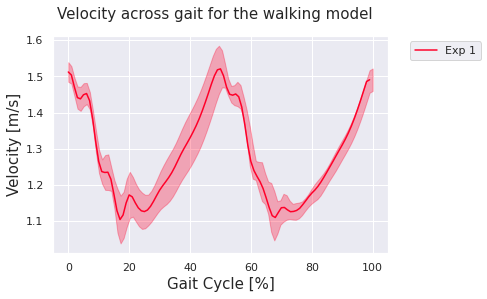

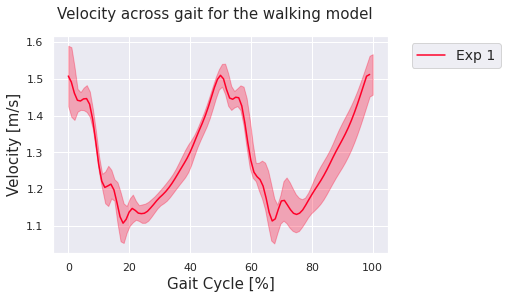

In [11]:
# Retrieve velocity from the optimizations.
velocity = {}
for test_id, test in data.items():
        velocity[test_id] = [test['values'][i]["pelvis"]["vel"][0] for i in range(len(test['values']))]

# Determine the maximum and mean velocity during one simulation
max_vel = {}
mean_vel = {}
for test_id, vel in velocity.items():
        max_vel[test_id] = np.max(vel)
        mean_vel[test_id] = np.mean(vel)
        
# Normalize data
velocity_norm_l = {}
velocity_norm_r = {}
for test_id, vel in velocity.items():
    velocity_norm_l[test_id] = getNormalizedData(vel, START_CYCLE_l[test_id][:-1], START_CYCLE_l[test_id][1:]-1)
    velocity_norm_r[test_id] = getNormalizedData(vel, START_CYCLE_r[test_id][:-1], START_CYCLE_r[test_id][1:]-1)

# Plot of the velocity during the whole simulation
for test_id in velocity_norm_l.keys():
    textstr = (r'%.4f' % (max_vel[test_id], ))
    plotWithStd(velocity_norm_l[test_id], 'Velocity across gait for the walking model', 'Gait Cycle [%]', 'Velocity [m/s]',  'Exp {}'.format(test_id), test_color[test_id])
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, )
        # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plt.show()


# Plot of the velocity during the whole simulation
for test_id in velocity_norm_r.keys():
    textstr = (r'%.4f' % (max_vel[test_id], ))
    plotWithStd(velocity_norm_r[test_id], 'Velocity across gait for the walking model', 'Gait Cycle [%]', 'Velocity [m/s]',  'Exp {}'.format(test_id), test_color[test_id])
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, prop={'size':14})
        # INFO : Move this code outside of the for loop (Just unindent it) to display all plots in one chart
plt.show()

### Gait Analysis 

From the ground reaction forces, we could obtain the stance, swing and complete cycle durations. From this, we can count the number of steps per leg for one optimization, and determine the average step length and average step duration.

In [12]:
# Retrieve velocity from the optimizations.
velocity = {}
for test_id, test in data.items():
        velocity[test_id] = [test['values'][i]["pelvis"]["vel"][0] for i in range(len(test['values']))]

velocity_body = {}
# Getting rid of the trailing non-accomplished steps
for test_id in START_CYCLE_l.keys():
    start_time_ms = START_CYCLE_l[test_id][0]
    velocity_body[test_id] = velocity[test_id][start_time_ms:]
    START_CYCLE_l[test_id] = np.array([i - start_time_ms for i in START_CYCLE_l[test_id]])

for test_id in START_CYCLE_r.keys():
    start_time_ms = START_CYCLE_r[test_id][0]
    START_CYCLE_r[test_id] = np.array([i - start_time_ms for i in START_CYCLE_r[test_id]])

general_mean_duration = {}    
general_duration = {}
    
for test_id, val in START_CYCLE_l.items():
    print()
    print("TEST: ", test_id)
    temp_steps_duration = []
    index = 1
    previousval = 0
    for v in val[1:]:
            print("STEP", index, " : ", (v - previousval)/100)
            temp_steps_duration.append(v - previousval)
            previousval = v
            index += 1
    general_mean_duration[test_id] = np.mean(temp_steps_duration)/100    
    general_duration[test_id] = np.sum(temp_steps_duration)/100
    print("MEAN STEP DURATION ", np.mean(temp_steps_duration)/100)
print()
print()
general_mean_length = {}
general_mean_velocity = {}
velocity_per_steps = {}
for test_id in velocity.keys():
    previousval = 0
    velocity_per_steps[test_id] = []
    for cycle in START_CYCLE_l[test_id]:
        if(cycle != 0):
            velocity_per_steps[test_id].append(np.mean(velocity_body[test_id][previousval:cycle]))
        previousval = cycle
    general_mean_velocity[test_id] = np.mean(velocity_per_steps[test_id])
    general_mean_length[test_id] = (general_mean_velocity[test_id] * general_duration[test_id]) + 0.6
# + 0.6 to take into account the fact that the simulation ends during a step. 
    
print("MEAN DURATION (s)", general_mean_duration)
print("VELOCITY (m/s)", general_mean_velocity)
print("DISTANCE (m)", general_mean_length)
print()
print()
for test_id in START_CYCLE_l.keys():
    print()
    print("TEST", test_id)
    print("DISTANCE PER STEP (m)", general_mean_length[test_id] / (len(START_CYCLE_l[test_id]) + len(START_CYCLE_r[test_id])))
    print("DURATION PER STEP (ms)", general_mean_duration[test_id])


TEST:  1
STEP 1  :  1.21
STEP 2  :  1.26
STEP 3  :  1.23
STEP 4  :  1.23
STEP 5  :  1.26
STEP 6  :  1.2
STEP 7  :  1.25
MEAN STEP DURATION  1.2342857142857142


MEAN DURATION (s) {'1': 1.2342857142857142}
VELOCITY (m/s) {'1': 1.2829341526537326}
DISTANCE (m) {'1': 11.68455107892825}



TEST 1
DISTANCE PER STEP (m) 0.6873265340546029
DURATION PER STEP (ms) 1.2342857142857142
